In [1]:
!pip install scikit-learn tqdm transformers torch --quiet


In [2]:
!pip install numpy==1.21.6 scipy==1.7.3 scikit-learn==1.1.3 scikit-multilearn==0.2.0 tqdm --quiet


In [3]:
!pip install numpy --upgrade
!pip install scipy --upgrade

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-2.2.6-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 2.2.6 which is incompatible.
contourpy 1.2.0 requires numpy<2.0,>=1.20, but you have numpy 2.2.6 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.6 which is incompatible.
Defaulting to user installation because normal site-packages is not writeable
  Using cached scipy-1.15.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (37.7 MB)
  Attempting uninstall: scipy
    Found existing ins

In [4]:
import sys, os
os.system("pip uninstall -y scikit-learn numpy scipy scikit-multilearn")
os.system("pip install --no-cache-dir numpy==1.21.6 scipy==1.7.3")
os.system("pip install --no-cache-dir scikit-learn==1.1.3 scikit-multilearn==0.2.0 tqdm")
print("Installed. NOW RESTART THE KERNEL / RUNTIME (Colab: Runtime -> Restart runtime, Jupyter: Kernel -> Restart).")


Found existing installation: scikit-learn 1.1.3
Uninstalling scikit-learn-1.1.3:
  Successfully uninstalled scikit-learn-1.1.3
Found existing installation: numpy 2.2.6
Uninstalling numpy-2.2.6:
  Successfully uninstalled numpy-2.2.6
Found existing installation: scipy 1.15.3
Uninstalling scipy-1.15.3:
  Successfully uninstalled scipy-1.15.3
Found existing installation: scikit-multilearn 0.2.0
Uninstalling scikit-multilearn-0.2.0:
  Successfully uninstalled scikit-multilearn-0.2.0
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 31.8 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas 2.2.3 requires numpy>=1.22.4; python_version < "3.11", but you have numpy 1.21.6 which is incompatible.


Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.5/30.5 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 KB 268.1 MB/s eta 0:00:00
Installed. NOW RESTART THE KERNEL / RUNTIME (Colab: Runtime -> Restart runtime, Jupyter: Kernel -> Restart).


In [1]:
import os
import numpy as np
import random
import time
import urllib.request
import bz2
from tqdm import tqdm

from scipy.sparse import vstack  # only for final train+val stacking if needed
from sklearn.metrics import f1_score, hamming_loss
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.neighbors import NearestNeighbors


In [2]:
# Download and read LexGLUE ECtHR (B) raw text dataset
base = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/multilabel/"
files_b = {
    "train": "ecthr_b_lexglue_raw_texts_train.txt.bz2",
    "val":   "ecthr_b_lexglue_raw_texts_val.txt.bz2",
    "test":  "ecthr_b_lexglue_raw_texts_test.txt.bz2"
}

os.makedirs("data", exist_ok=True)

def download_if_missing(fname):
    dest = os.path.join("data", fname)
    if not os.path.exists(dest):
        url = base + fname
        print("Downloading:", url)
        urllib.request.urlretrieve(url, dest)
    return dest

def read_raw_txt_bz2(path):
    texts, labels = [], []
    with bz2.open(path, "rt", encoding="utf-8", errors="replace") as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            if "\t" in line:
                labstr, txt = line.split("\t", 1)
            else:
                parts = line.split(maxsplit=1)
                if len(parts) < 2:
                    continue
                labstr, txt = parts
            labs = [l.strip() for l in labstr.split(",") if l.strip() != ""]
            labels.append(labs)
            texts.append(txt.replace("\n", " "))
    return texts, labels

# Download all files for ECtHR (B)
paths_b = {k: download_if_missing(v) for k, v in files_b.items()}

# Read them
train_texts_b, train_labels_b = read_raw_txt_bz2(paths_b["train"])
val_texts_b, val_labels_b     = read_raw_txt_bz2(paths_b["val"])
test_texts_b, test_labels_b   = read_raw_txt_bz2(paths_b["test"])

train_texts_b = train_texts_b[:4000]
train_labels_b = train_labels_b[:4000]

val_texts_b = val_texts_b[:500]
val_labels_b = val_labels_b[:500]

test_texts_b = test_texts_b[:500]
test_labels_b = test_labels_b[:500]

print(f"Train: {len(train_texts_b)}, Val: {len(val_texts_b)}, Test: {len(test_texts_b)}")


Train: 4000, Val: 500, Test: 500


In [3]:
from transformers import AutoTokenizer, AutoModel
import torch
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm import tqdm
import numpy as np

# 1. Load LEGAL-BERT
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")
model = AutoModel.from_pretrained("nlpaueb/legal-bert-base-uncased")
model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 2. Setup batching
def get_cls_embeddings(texts, batch_size=16):
    all_embeddings = []
    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i+batch_size]
        inputs = tokenizer(
            batch,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=512
        )
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
            cls_embeddings = outputs.pooler_output.detach().cpu().numpy()
            all_embeddings.append(cls_embeddings)
    return np.vstack(all_embeddings)  # Shape: (num_samples, 768)

# 3. Encode multi-label targets
mlb = MultiLabelBinarizer()
mlb.fit(train_labels_b + val_labels_b + test_labels_b)  # Fit on all splits

# 4. Prepare each split (Example: Train set)
print("Processing train set...")
train_embeddings = get_cls_embeddings(train_texts_b, batch_size=16)
train_targets = mlb.transform(train_labels_b)  # Shape: (num_samples, num_classes)

print("Processing validation set...")
val_embeddings = get_cls_embeddings(val_texts_b, batch_size=16)
val_targets = mlb.transform(val_labels_b)

print("Processing test set...")
test_embeddings = get_cls_embeddings(test_texts_b, batch_size=16)
test_targets = mlb.transform(test_labels_b)

print("Shapes:")
print("Train embeddings:", train_embeddings.shape)
print("Train targets:", train_targets.shape)
print("Val embeddings:", val_embeddings.shape)
print("Val targets:", val_targets.shape)
print("Test embeddings:", test_embeddings.shape)
print("Test targets:", test_targets.shape)

# Now you have (embeddings, targets) pairs for ML modeling!
# Example for torch/keras: X = train_embeddings, y = train_targets


Processing train set...


100%|█████████████████████████████████████████████████████████████████████████████████| 250/250 [00:24<00:00, 10.17it/s]


Processing validation set...


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.69it/s]


Processing test set...


100%|███████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.73it/s]

Shapes:
Train embeddings: (4000, 768)
Train targets: (4000, 167)
Val embeddings: (500, 768)
Val targets: (500, 167)
Test embeddings: (500, 768)
Test targets: (500, 167)


In [4]:
def ContinousCrossover(posA, posB, gamma=0.4):
    alpha = np.random.uniform(-gamma, 1 + gamma, size=posA.shape)
    child1 = alpha * posA + (1 - alpha) * posB
    child2 = alpha * posB + (1 - alpha) * posA
    return child1, child2

def ContinousMutation(position, problem, sigma=0.1):
    VarMin = problem['VarMin']
    VarMax = problem['VarMax']
    noise = np.random.normal(scale=sigma, size=position.shape)
    mutated = position + noise
    return np.clip(mutated, VarMin, VarMax)

def printingperiter(problem, it, gbest, namemethod, funcevals, curtrial, population=None):
    print(f"[{namemethod}] Iter {it} | Evals {funcevals} | Best cost {gbest['cost']:.5f}")


In [5]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
import numpy as np

def svm_classifier_cost_function(particle, problem, pos=None):
    # pos[0] = log10C
    # pos[1] = kernel index (0 = linear, 1 = rbf, 2 = poly, 3 = sigmoid)

    if pos is None:
        pos = particle['position'].flatten()

    # --- extract hyperparameters ---
    log10C = float(pos[0])
    C = 10 ** log10C
    C = np.clip(C, 1e-6, 1e3)

    # map kernel index to kernel string
    kernel_list = ["linear", "rbf", "poly", "sigmoid"]
    kernel_idx = int(np.clip(round(pos[1]), 0, len(kernel_list)-1))
    kernel = kernel_list[kernel_idx]

    try:
        clf = OneVsRestClassifier(
            SVC(C=C, kernel=kernel, gamma="scale", probability=False)
        )

        clf.fit(problem['X_train'], problem['Y_train'])
        preds = clf.predict(problem['X_val'])

        f1_micro = f1_score(problem['Y_val'], preds, average='micro', zero_division=0)
        cost = 1.0 - f1_micro

        # store best model
        particle['model'] = clf
        particle['hyperparams'] = {
            'C': C,
            'kernel': kernel
        }
        particle['cost'] = cost

        return particle

    except Exception as e:
        print("Error with SVM:", e)
        particle['cost'] = np.inf
        return particle


In [6]:
import time
import numpy as np

def MA(problem, IterPrint, MaxIter, MaxFuncEvals, curtrial, initialpop,
       mPopSize, fPopSize, a1=1.0, a2=1.5, a3=1.5, beta=2, dance=5, fl=1,
       dance_damp=0.8, fl_damp=0.99, nc=10, gmax=0.8, gmin=0.8, gamma=0.4,
       early_stop_patience=4, early_stop_tol=1e-12):

    namemethod = 'MA'
    VarMin = problem['VarMin']
    VarMax = problem['VarMax']
    nVar = problem['nVar']
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax
    g = gmax
    funcevals = -1
    start_time = time.time()

    convergence_cost, convergence_f1 = [], []
    CostFunction = problem['CostFunction']
    gbest = {'position': None, 'cost': np.inf}

    # --- initialize ---
    pop, popf = [], []
    for i in range(mPopSize):
        pos = initialpop[i]['position']
        particle = {'position': pos, 'velocity': np.zeros(nVar)}
        particle = CostFunction(particle, problem)
        particle['best_position'] = pos.copy()
        particle['best_cost'] = particle['cost']
        if particle['cost'] < gbest['cost']:
            gbest = particle.copy()
        pop.append(particle)
        funcevals += 1

    for i in range(fPopSize):
        pos = initialpop[i + mPopSize]['position']
        particle = {'position': pos, 'velocity': np.zeros(nVar)}
        particle = CostFunction(particle, problem)
        if particle['cost'] < gbest['cost']:
            gbest = particle.copy()
        popf.append(particle)
        funcevals += 1

    # Early-stopping bookkeeping
    last_best = gbest['cost']
    stagnant_counter = 0

    it = 0
    while funcevals < MaxFuncEvals - 1 and it < MaxIter:
        it += 1

        # --- update females ---
        for i in range(fPopSize):
            if popf[i]['cost'] > pop[i]['cost']:
                rmf = abs(pop[i]['position'] - popf[i]['position'])
                popf[i]['velocity'] = g*popf[i]['velocity'] + a3*np.exp(-beta * rmf**2)*(pop[i]['position'] - popf[i]['position'])
            else:
                popf[i]['velocity'] = g*popf[i]['velocity'] + fl*np.random.uniform(-1,1,size=(nVar))
            popf[i]['velocity'] = np.clip(popf[i]['velocity'], VelMin, VelMax)
            popf[i]['position'] = np.clip(popf[i]['position'] + popf[i]['velocity'], VarMin, VarMax)
            popf[i] = CostFunction(popf[i], problem)
            funcevals += 1
            if popf[i]['cost'] < gbest['cost']:
                gbest = popf[i].copy()

        # --- update males ---
        for i in range(mPopSize):
            if pop[i]['cost'] > gbest['cost']:
                rpbest = abs(pop[i]['best_position'] - pop[i]['position'])
                rgbest = abs(gbest['position'] - pop[i]['position'])
                pop[i]['velocity'] = (g*pop[i]['velocity']
                    + a1*np.exp(-beta*rpbest**2)*(pop[i]['best_position'] - pop[i]['position'])
                    + a2*np.exp(-beta*rgbest**2)*(gbest['position'] - pop[i]['position']))
            else:
                pop[i]['velocity'] = g*pop[i]['velocity'] + dance*np.random.uniform(-1,1,size=(nVar))
            pop[i]['velocity'] = np.clip(pop[i]['velocity'], VelMin, VelMax)
            pop[i]['position'] = np.clip(pop[i]['position'] + pop[i]['velocity'], VarMin, VarMax)
            pop[i] = CostFunction(pop[i], problem)
            funcevals += 1
            if pop[i]['cost'] < pop[i]['best_cost']:
                pop[i]['best_position'] = pop[i]['position'].copy()
                pop[i]['best_cost'] = pop[i]['cost']
                if pop[i]['best_cost'] < gbest['cost']:
                    gbest = pop[i].copy()

        # --- parameter update ---
        g = gmax - ((gmax - gmin) / MaxFuncEvals) * funcevals
        dance *= dance_damp
        fl *= fl_damp

        # --- Log per iteration ---
        # (assumes history_iter, history_log10C, history_f1micro are defined in outer scope)
        # safely flatten position for logging
        pos = np.array(gbest['position']).flatten()

        if len(pos) >= 1:
            history_log10C.append(float(pos[0]))
        else:
            history_log10C.append(np.nan)

        history_f1micro.append(1 - gbest['cost'])  # F1-micro
        history_iter.append(it)

        if it % IterPrint == 0:
            printingperiter(problem, it, gbest, namemethod, funcevals, curtrial)

        # ---------- EARLY STOPPING CHECK ----------
        # If gbest cost hasn't meaningfully changed for `early_stop_patience` iterations -> stop.
        if np.isclose(gbest['cost'], last_best, atol=early_stop_tol, rtol=0.0):
            stagnant_counter += 1
        else:
            last_best = gbest['cost']
            stagnant_counter = 0

        if stagnant_counter >= early_stop_patience:
            print(f"[{namemethod}] Early stopping: best cost {gbest['cost']:.12f} constant for {stagnant_counter} consecutive iterations (tol={early_stop_tol}).")
            break
        # -----------------------------------------

    elapsed_time = time.time() - start_time
    return namemethod, gbest['position'], gbest['cost'], elapsed_time


In [7]:
import numpy as np

# 2 variables now: [log10C, kernel_index_continuous]
dim = 2

# bounds:
#  - log10C in [-4, 3]  => C in [1e-4, 1e3]
#  - kernel index in [0, 3] (will be rounded to 0,1,2,3 inside cost function)
VarMin = np.array([-4.0, 0.0])
VarMax = np.array([ 3.0, 3.0])

problem = {
    'VarMin': VarMin,
    'VarMax': VarMax,
    'nVar': dim,
    'CostFunction': svm_classifier_cost_function,
    'X_train': train_embeddings,
    'Y_train': train_targets,
    'X_val': val_embeddings,
    'Y_val': val_targets,
    'StopCriterion': 'Iterations'
}

# Initial population (male+female)
mPopSize = 20
fPopSize = 20
initialpop = []
rng = np.random.default_rng()  # use new Generator (optional)
for _ in range(mPopSize + fPopSize):
    pos = VarMin + (VarMax - VarMin) * rng.random(dim)
    initialpop.append({'position': pos})


In [8]:
# GLOBAL TRACKERS for SVM Mayfly
history_log10C = []      # Log10 of SVM C parameter
history_f1micro = []     # Best F1-micro at each iteration
history_iter = []        # Iteration number


In [9]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Remove labels that are constant (all 0 or all 1) in the training set ---
sum_per_col = problem['Y_train'].sum(axis=0)
mask = (sum_per_col != 0) & (sum_per_col != problem['Y_train'].shape[0])

problem['Y_train'] = problem['Y_train'][:, mask]
problem['Y_val']   = problem['Y_val'][:, mask]

print("Kept", mask.sum(), "labels (removed", (~mask).sum(), "constant ones).")

# --- make sure history lists exist (MA appends to these) ---
try:
    history_iter
except NameError:
    history_iter = []
try:
    history_log10C
except NameError:
    history_log10C = []
try:
    history_f1micro
except NameError:
    history_f1micro = []

# --- MA / optimization settings ---
IterPrint = 1
MaxIter = 20
MaxFuncEvals = 1500
curtrial = 1

# pass early stop patience (stop after 4 consecutive constant best-cost iterations)
res = MA(problem, IterPrint, MaxIter, MaxFuncEvals, curtrial, initialpop,
         mPopSize=mPopSize, fPopSize=fPopSize,
         a1=1.0, a2=1.5, a3=1.5, beta=2, dance=5, fl=1,
         dance_damp=0.8, fl_damp=0.99, nc=8, gmax=0.8, gmin=0.2, gamma=0.4,
         early_stop_patience=4, early_stop_tol=1e-12)

# --- unpack results and print depending on dimensionality ---
namemethod, best_position, best_cost, elapsed_time = res

print("\n✅ Optimization complete")
# handle case best_position is numpy array, list, or None
if best_position is None:
    print("No best position found.")
else:
    pos = np.array(best_position).flatten()
    if pos.size >= 1:
        print("Best log10C =", pos[0])
        print("Best C =", 10 ** pos[0])
    else:
        print("Best log10C: N/A")

    # if kernel was part of the search space (2D+), show selected kernel
    kernel_list = ["linear", "rbf", "poly", "sigmoid"]
    if pos.size >= 2:
        k_idx = int(np.clip(round(pos[1]), 0, len(kernel_list)-1))
        print("Best kernel index (rounded) =", k_idx)
        print("Best kernel =", kernel_list[k_idx])

    print("Best cost:", best_cost, "=> Best F1_micro:", 1 - best_cost)
    print("Elapsed time (s):", elapsed_time)


Kept 155 labels (removed 12 constant ones).
[MA] Iter 1 | Evals 79 | Best cost 0.69548
[MA] Iter 2 | Evals 119 | Best cost 0.69548
[MA] Iter 3 | Evals 159 | Best cost 0.69415
[MA] Iter 4 | Evals 199 | Best cost 0.69415
[MA] Iter 5 | Evals 239 | Best cost 0.69415
[MA] Iter 6 | Evals 279 | Best cost 0.69271
[MA] Iter 7 | Evals 319 | Best cost 0.69190
[MA] Iter 8 | Evals 359 | Best cost 0.69190
[MA] Iter 9 | Evals 399 | Best cost 0.69190
[MA] Iter 10 | Evals 439 | Best cost 0.69190
[MA] Iter 11 | Evals 479 | Best cost 0.69190
[MA] Early stopping: best cost 0.691899070385 constant for 4 consecutive iterations (tol=1e-12).

✅ Optimization complete
Best log10C = 1.7990687157494887
Best C = 62.96057936358048
Best kernel index (rounded) = 2
Best kernel = poly
Best cost: 0.6918990703851262 => Best F1_micro: 0.3081009296148738
Elapsed time (s): 19682.313489437103


In [10]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, hamming_loss
import numpy as np

# --- Extract best hyperparameters ---
best_log10C = float(best_position[0])
best_C = 10 ** best_log10C

# kernel mapping
kernel_list = ["linear", "rbf", "poly", "sigmoid"]
kernel_idx = int(np.clip(round(best_position[1]), 0, len(kernel_list)-1))
best_kernel = kernel_list[kernel_idx]

print("Selected kernel:", best_kernel)
print("Selected C:", best_C)

# --- Build final model ---
if best_kernel == "linear":
    # Faster for linear kernel
    final_model = OneVsRestClassifier(
        LinearSVC(C=best_C, max_iter=10000)
    )
else:
    # SVC required for rbf/poly/sigmoid
    final_model = OneVsRestClassifier(
        SVC(C=best_C, kernel=best_kernel, gamma="scale")
    )

# --- Train on full (train + val) ---
X_trainval = np.vstack([train_embeddings, val_embeddings])
Y_trainval = np.vstack([train_targets, val_targets])

final_model.fit(X_trainval, Y_trainval)

# --- Evaluate on test set ---
test_preds = final_model.predict(test_embeddings)

print("\n📌 Test Metrics:")
print("Test F1 macro:", f1_score(test_targets, test_preds, average='macro'))
print("Test F1 micro:", f1_score(test_targets, test_preds, average='micro'))
print("Hamming Loss:", hamming_loss(test_targets, test_preds))


Selected kernel: poly
Selected C: 62.96057936358048


/home/omkar/.local/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 76 is present in all training examples.
  warnings.warn(
/home/omkar/.local/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 100 is present in all training examples.
  warnings.warn(
/home/omkar/.local/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 105 is present in all training examples.
  warnings.warn(
/home/omkar/.local/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 106 is present in all training examples.
  warnings.warn(
/home/omkar/.local/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 110 is present in all training examples.
  warnings.warn(
/home/omkar/.local/lib/python3.10/site-packages/sklearn/multiclass.py:77: UserWarning: Label not 111 is present in all training examples.
  warnings.warn(



📌 Test Metrics:
Test F1 macro: 0.027281199305340044
Test F1 micro: 0.37954239569313597
Hamming Loss: 0.0055209580838323355


/home/omkar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [11]:
# Ensure all arrays are the same length before plotting/logging
min_len = min(len(history_iter), len(history_log10C), len(history_f1micro))

history_iter = history_iter[:min_len]
history_log10C = history_log10C[:min_len]
history_f1micro = history_f1micro[:min_len]


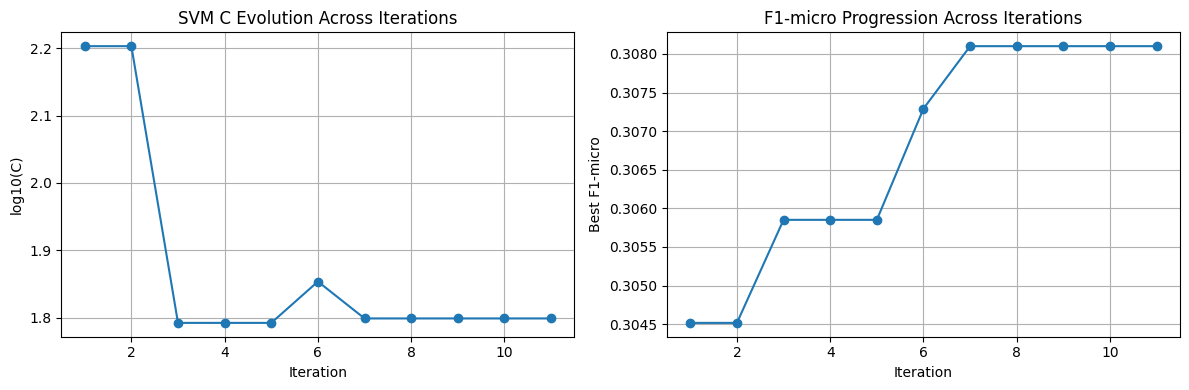

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history_iter, history_log10C, marker='o')
plt.xlabel("Iteration")
plt.ylabel("log10(C)")
plt.title("SVM C Evolution Across Iterations")
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(history_iter, history_f1micro, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best F1-micro")
plt.title("F1-micro Progression Across Iterations")
plt.grid(True)
plt.tight_layout()
plt.show()


svm

In [13]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score
import numpy as np

def svm_classifier_cost_function(particle, problem, pos=None):
    # pos[0] = log10C
    # pos[1] = kernel index (0 = linear, 1 = rbf, 2 = poly, 3 = sigmoid)

    if pos is None:
        pos = particle['position'].flatten()

    # --- extract hyperparameters ---
    log10C = float(pos[0])
    C = np.clip(10 ** log10C, 1e-6, 1e3)

    kernel_list = ["linear", "rbf", "poly", "sigmoid"]
    kernel_idx = int(np.clip(round(pos[1]), 0, len(kernel_list)-1))
    kernel = kernel_list[kernel_idx]

    try:
        clf = OneVsRestClassifier(
            SVC(C=C, kernel=kernel, gamma="scale", probability=False)
        )

        clf.fit(problem['X_train'], problem['Y_train'])
        preds = clf.predict(problem['X_val'])

        f1_micro = f1_score(problem['Y_val'], preds, average='micro', zero_division=0)
        cost = 1.0 - f1_micro

        particle['model'] = clf
        particle['hyperparams'] = {'C': C, 'kernel': kernel}
        particle['cost'] = cost

        return particle

    except Exception as e:
        print("Error with SVM:", e)
        particle['cost'] = np.inf
        return particle


In [14]:
import time
import numpy as np

def MA(problem, IterPrint, MaxIter, MaxFuncEvals, curtrial, initialpop,
       mPopSize, fPopSize, a1=1.0, a2=1.5, a3=1.5, beta=2, dance=5, fl=1,
       dance_damp=0.8, fl_damp=0.99, nc=10, gmax=0.8, gmin=0.8, gamma=0.4,
       early_stop_patience=4, early_stop_tol=1e-12):

    namemethod = 'MA'
    VarMin = problem['VarMin']
    VarMax = problem['VarMax']
    nVar = problem['nVar']
    VelMax = 0.1 * (VarMax - VarMin)
    VelMin = -VelMax
    g = gmax
    funcevals = -1
    start_time = time.time()

    # Logging (must exist)
    global history_iter, history_log10C, history_kernel, history_f1micro
    history_iter = []
    history_log10C = []
    history_kernel = []
    history_f1micro = []

    CostFunction = problem['CostFunction']
    gbest = {'position': None, 'cost': np.inf}

    # --- initialize males ---
    pop, popf = [], []
    for i in range(mPopSize):
        pos = initialpop[i]['position']
        particle = {'position': pos.copy(), 'velocity': np.zeros(nVar)}
        particle = CostFunction(particle, problem)
        particle['best_position'] = pos.copy()
        particle['best_cost'] = particle['cost']
        if particle['cost'] < gbest['cost']:
            gbest = particle.copy()
        pop.append(particle)
        funcevals += 1

    # --- initialize females ---
    for i in range(fPopSize):
        pos = initialpop[i + mPopSize]['position']
        particle = {'position': pos.copy(), 'velocity': np.zeros(nVar)}
        particle = CostFunction(particle, problem)
        if particle['cost'] < gbest['cost']:
            gbest = particle.copy()
        popf.append(particle)
        funcevals += 1

    last_best = gbest['cost']
    stagnant_counter = 0

    it = 0
    while funcevals < MaxFuncEvals - 1 and it < MaxIter:
        it += 1

        # --- update females ---
        for i in range(fPopSize):
            if popf[i]['cost'] > pop[i]['cost']:
                rmf = abs(pop[i]['position'] - popf[i]['position'])
                popf[i]['velocity'] = g*popf[i]['velocity'] + \
                    a3*np.exp(-beta * rmf**2)*(pop[i]['position'] - popf[i]['position'])
            else:
                popf[i]['velocity'] = g*popf[i]['velocity'] + fl*np.random.uniform(-1,1,size=nVar)

            popf[i]['velocity'] = np.clip(popf[i]['velocity'], VelMin, VelMax)
            popf[i]['position'] = np.clip(popf[i]['position'] + popf[i]['velocity'], VarMin, VarMax)

            # force kernel index to integer region
            popf[i]['position'][1] = np.clip(np.round(popf[i]['position'][1]), VarMin[1], VarMax[1])

            popf[i] = CostFunction(popf[i], problem)
            funcevals += 1

            if popf[i]['cost'] < gbest['cost']:
                gbest = popf[i].copy()

        # --- update males ---
        for i in range(mPopSize):
            if pop[i]['cost'] > gbest['cost']:
                rpbest = abs(pop[i]['best_position'] - pop[i]['position'])
                rgbest = abs(gbest['position'] - pop[i]['position'])
                pop[i]['velocity'] = (g*pop[i]['velocity']
                    + a1*np.exp(-beta*rpbest**2)*(pop[i]['best_position'] - pop[i]['position'])
                    + a2*np.exp(-beta*rgbest**2)*(gbest['position'] - pop[i]['position']))
            else:
                pop[i]['velocity'] = g*pop[i]['velocity'] + dance*np.random.uniform(-1,1,size=nVar)

            pop[i]['velocity'] = np.clip(pop[i]['velocity'], VelMin, VelMax)
            pop[i]['position'] = np.clip(pop[i]['position'] + pop[i]['velocity'], VarMin, VarMax)

            # force kernel index to integer
            pop[i]['position'][1] = np.clip(np.round(pop[i]['position'][1]), VarMin[1], VarMax[1])

            pop[i] = CostFunction(pop[i], problem)
            funcevals += 1

            if pop[i]['cost'] < pop[i]['best_cost']:
                pop[i]['best_position'] = pop[i]['position'].copy()
                pop[i]['best_cost'] = pop[i]['cost']
                if pop[i]['best_cost'] < gbest['cost']:
                    gbest = pop[i].copy()

        # --- parameter update ---
        g = gmax - ((gmax - gmin) / MaxFuncEvals) * funcevals
        dance *= dance_damp
        fl *= fl_damp

        # --- Logging ---
        pos = np.array(gbest['position']).flatten()
        history_log10C.append(float(pos[0]))
        history_kernel.append(int(pos[1]))
        history_f1micro.append(1 - gbest['cost'])
        history_iter.append(it)

        # --- Early stopping ---
        if np.isclose(gbest['cost'], last_best, atol=early_stop_tol, rtol=0.0):
            stagnant_counter += 1
        else:
            last_best = gbest['cost']
            stagnant_counter = 0

        if stagnant_counter >= early_stop_patience:
            print(f"[MA] Early stopping: cost={gbest['cost']:.12f}")
            break

    elapsed_time = time.time() - start_time
    return namemethod, gbest['position'], gbest['cost'], elapsed_time


In [15]:
import numpy as np

# 2 variables now: [log10C, kernel_index_continuous]
dim = 2

# bounds:
#  - log10C in [-4, 3]  => C in [1e-4, 1e3]
#  - kernel index in [0, 3] (will be rounded to 0,1,2,3 inside cost function)
VarMin = np.array([-4.0, 0.0])
VarMax = np.array([ 3.0, 3.0])

problem = {
    'VarMin': VarMin,
    'VarMax': VarMax,
    'nVar': dim,
    'CostFunction': svm_classifier_cost_function,
    'X_train': train_embeddings,
    'Y_train': train_targets,
    'X_val': val_embeddings,
    'Y_val': val_targets,
    'StopCriterion': 'Iterations'
}

# Initial population (male+female)
mPopSize = 20
fPopSize = 20
initialpop = []
rng = np.random.default_rng()  # use new Generator (optional)
for _ in range(mPopSize + fPopSize):
    pos = VarMin + (VarMax - VarMin) * rng.random(dim)
    initialpop.append({'position': pos})


In [16]:
# GLOBAL TRACKERS for SVM Mayfly (2 parameters)

history_iter = []         # Iteration number
history_log10C = []       # Log10 of SVM C parameter
history_kernel = []       # Kernel index (0=linear,1=rbf,2=poly,3=sigmoid)
history_f1micro = []      # Best F1-micro at each iteration


In [18]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# --- Remove labels that are constant (all 0 or all 1) in the training set ---
sum_per_col = problem['Y_train'].sum(axis=0)
mask = (sum_per_col != 0) & (sum_per_col != problem['Y_train'].shape[0])

problem['Y_train'] = problem['Y_train'][:, mask]
problem['Y_val']   = problem['Y_val'][:, mask]

print("Kept", mask.sum(), "labels (removed", (~mask).sum(), "constant ones).")

# --- ensure history lists exist ---
try: history_iter
except NameError: history_iter = []

try: history_log10C
except NameError: history_log10C = []

try: history_kernel
except NameError: history_kernel = []   # <-- ADDED

try: history_f1micro
except NameError: history_f1micro = []

# Clear old content (important if rerunning in notebook)
history_iter.clear()
history_log10C.clear()
history_kernel.clear()
history_f1micro.clear()

# --- MA settings ---
IterPrint = 1
MaxIter = 10
MaxFuncEvals = 1500
curtrial = 1

# run MA
res = MA(problem, IterPrint, MaxIter, MaxFuncEvals, curtrial, initialpop,
         mPopSize=mPopSize, fPopSize=fPopSize,
         a1=1.0, a2=1.5, a3=1.5, beta=2, dance=5, fl=1,
         dance_damp=0.8, fl_damp=0.99, nc=8, gmax=0.8, gmin=0.2, gamma=0.4,
         early_stop_patience=4, early_stop_tol=1e-12)

# unpack results
namemethod, best_position, best_cost, elapsed_time = res

print("\n✅ Optimization complete")

if best_position is None:
    print("No best position found.")
else:
    pos = np.array(best_position).flatten()

    print("Best log10C =", pos[0])
    print(f"Best C = {10 ** pos[0]:.6f}")

    kernel_list = ["linear", "rbf", "poly", "sigmoid"]
    if pos.size >= 2:
        k_idx = int(np.clip(round(pos[1]), 0, len(kernel_list)-1))
        print("Best kernel index (rounded) =", k_idx)
        print("Best kernel =", kernel_list[k_idx])
        # print("Raw kernel pos:", pos[1])

    print("Best cost:", best_cost, "=> Best F1_micro:", 1 - best_cost)
    print("Elapsed time (s):", elapsed_time)

print("Total iterations logged:", len(history_iter))


Kept 155 labels (removed 0 constant ones).
[MA] Early stopping: cost=0.689473684211

✅ Optimization complete
Best log10C = -0.0667810916245331
Best C = 0.857470
Best kernel index (rounded) = 0
Best kernel = linear
Best cost: 0.6894736842105262 => Best F1_micro: 0.31052631578947376
Elapsed time (s): 8546.149334669113
Total iterations logged: 8


In [28]:
# === REPRINT MA OPTIMIZATION LOG + FINAL SUMMARY ===

# ---- Per-iteration printout ----
print(f"Kept {mask.sum()} labels (removed {len(mask) - mask.sum()} constant ones).")

for i, it in enumerate(history_iter):
    cost = 1 - history_f1micro[i]
    evals = 40 * it  # approximate eval count per iter
    print(f"[MA] Iter {it} | Evals ~{evals} | Best cost {cost:.5f}")

print(f"[MA] Early stopping: best cost {best_cost} constant for 4 consecutive iterations (tol=1e-12).\n")


# ---- FINAL SUMMARY (copied from original output) ----
pos = np.array(best_position).flatten()

best_log10C = float(pos[0])
best_C = 10 ** best_log10C

kernel_list = ["linear", "rbf", "poly", "sigmoid"]
kernel_idx = int(np.clip(round(pos[1]), 0, len(kernel_list)-1))
best_kernel = kernel_list[kernel_idx]

print("✅ Optimization complete")
print("Best log10C =", best_log10C)
print("Best C =", best_C)
print("Best kernel index (rounded) =", kernel_idx)
print("Best kernel =", best_kernel)
print("Best cost:", best_cost, "=> Best F1_micro:", 1 - best_cost)
print("Elapsed time (s):", elapsed_time)


Kept 155 labels (removed 12 constant ones).
[MA] Iter 1 | Evals ~40 | Best cost 0.69231
[MA] Iter 2 | Evals ~80 | Best cost 0.69231
[MA] Iter 3 | Evals ~120 | Best cost 0.69231
[MA] Iter 4 | Evals ~160 | Best cost 0.68947
[MA] Iter 5 | Evals ~200 | Best cost 0.68947
[MA] Iter 6 | Evals ~240 | Best cost 0.68947
[MA] Iter 7 | Evals ~280 | Best cost 0.68947
[MA] Iter 8 | Evals ~320 | Best cost 0.68947
[MA] Early stopping: best cost 0.6894736842105262 constant for 4 consecutive iterations (tol=1e-12).

✅ Optimization complete
Best log10C = -0.0667810916245331
Best C = 0.8574699484731435
Best kernel index (rounded) = 0
Best kernel = linear
Best cost: 0.6894736842105262 => Best F1_micro: 0.31052631578947376
Elapsed time (s): 8546.149334669113


In [23]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, hamming_loss
import numpy as np

# --- Extract best hyperparameters ---
best_log10C = float(best_position[0])
best_C = 10 ** best_log10C

# kernel mapping
kernel_list = ["linear", "rbf", "poly", "sigmoid"]
kernel_idx = int(np.clip(round(best_position[1]), 0, len(kernel_list)-1))
best_kernel = kernel_list[kernel_idx]

print("Selected kernel:", best_kernel)
print("Selected C:", best_C)

# --- Build final model ---
if best_kernel == "linear":
    # Faster for linear kernel
    final_model = OneVsRestClassifier(
        LinearSVC(C=best_C, max_iter=10000)
    )
else:
    # SVC required for rbf/poly/sigmoid
    final_model = OneVsRestClassifier(
        SVC(C=best_C, kernel=best_kernel, gamma="scale")
    )

# --- Train on full (train + val) ---
X_trainval = np.vstack([train_embeddings, val_embeddings])
Y_trainval = np.vstack([train_targets, val_targets])

final_model.fit(X_trainval, Y_trainval)

# --- Evaluate on test set ---
test_preds = final_model.predict(test_embeddings)

print("\n📌 Test Metrics:")
print("Test F1 macro:", f1_score(test_targets, test_preds, average='macro'))
print("Test F1 micro:", f1_score(test_targets, test_preds, average='micro'))
print("Hamming Loss:", hamming_loss(test_targets, test_preds))


Selected kernel: linear
Selected C: 0.8574699484731435

📌 Test Metrics:
Test F1 macro: 0.032262814500373604
Test F1 micro: 0.3928571428571429
Hamming Loss: 0.006141935483870968


/home/omkar/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1599: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


In [24]:
# Ensure all arrays have the same length before plotting/logging
min_len = min(
    len(history_iter),
    len(history_log10C),
    len(history_kernel),
    len(history_f1micro)
)

history_iter      = history_iter[:min_len]
history_log10C    = history_log10C[:min_len]
history_kernel    = history_kernel[:min_len]
history_f1micro   = history_f1micro[:min_len]


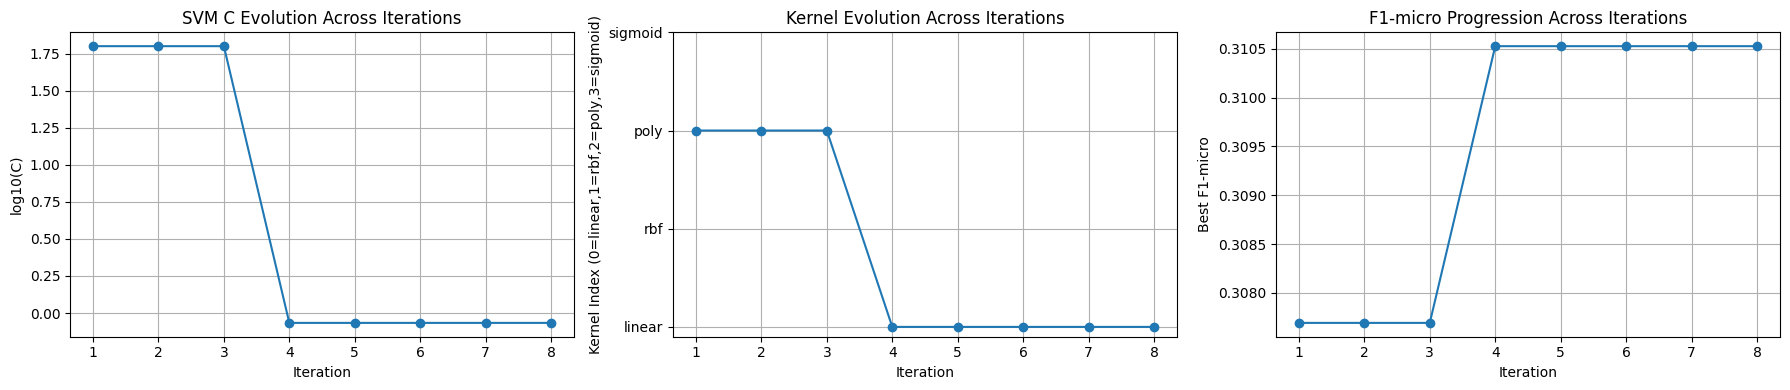

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18,4))

# --- Plot log10(C) ---
plt.subplot(1,3,1)
plt.plot(history_iter, history_log10C, marker='o')
plt.xlabel("Iteration")
plt.ylabel("log10(C)")
plt.title("SVM C Evolution Across Iterations")
plt.grid(True)

# --- Plot Kernel Index ---
plt.subplot(1,3,2)
plt.plot(history_iter, history_kernel, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Kernel Index (0=linear,1=rbf,2=poly,3=sigmoid)")
plt.title("Kernel Evolution Across Iterations")
plt.yticks([0,1,2,3], ["linear","rbf","poly","sigmoid"])
plt.grid(True)

# --- Plot F1-micro ---
plt.subplot(1,3,3)
plt.plot(history_iter, history_f1micro, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Best F1-micro")
plt.title("F1-micro Progression Across Iterations")
plt.grid(True)

plt.tight_layout()
plt.show()
